# Restaurant Recommendations

In this Notebook we demonstrate the following: 

* Generate restaurant/dish recommendations for a user that is registered with Zess app and have previously selected meals that they like or dislike.

* Score and rank the recommended items based on their nutritional profile and allergy safety.

* Perform data analysis and visualisation of the correlation between eat-well score of a meal and the meal's nutrient properties, to show which nutrient properties negatively or positevely affect the Eat-Well score.

* Demonstrate Harris-Benedict TDEE calculation.

### User preference and taste based restaurant recommendations

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from eat_well.energy_calc import tdee

In [3]:
local_path = "./q3/RippleNet/"
import pickle
import json
import sys
import os
sys.path.append(local_path + "src/Presentation")
import torch
from pandas import option_context
import postprocess
from postprocess import *
from eat_well.usecase_manager import Usecase_Manager
from eat_well.eat_well_score_generator import load_process_subgraph, eat_well_score_calculator, eat_well_scores_calculator
import pandas as pd
from eat_well.generate_plots import generate_plots
import numpy as np
import matplotlib.pyplot as plt
from q3.RippleNet.src.Presentation.postprocess import ripplenet_predict
from math import *

ratings_filepath = local_path + "data/restaurant/raw_ratings.txt"
model_filepath = local_path + "data/py_model.pkl"

Let's calculate the users TDEE first

In [20]:
gender, weight, weight_units, height, height_units, age = 'male', 100, 'kg', 178, 'cm', 28
meals_per_day = 3
energy_percent = 20
print("We calculate TDEE for an individual that has the following properties: \n age: ", age, "\n sex: ", gender, "\n weight: ", weight, "kg \n height: ", height, "\n\n")

def tdee_macro_calculator(energy):
    
    carbohydrates_percentage = 0.55
    protein_percentage = 0.225
    fat_percentage = 0.275
    kcal_per_g_carbs = 4
    kcal_per_g_protein = 4
    kcal_per_g_fat = 9
    
    #recommended macro intake quantities in grams
    recommended_carbohydrates_intake = carbohydrates_percentage * energy / 4
    recommended_protein_intake = protein_percentage * energy / 4
    recommended_fat_intake = fat_percentage * energy / 9
    
    return recommended_carbohydrates_intake, recommended_protein_intake, recommended_fat_intake

energy = tdee(gender , weight, weight_units, height, height_units , age, activity_level='moderate')
print(f'This individual requires approximately {round(energy)} kcals to stay the same weight.')
carbs, protein, fat = tdee_macro_calculator(energy)
print('They can therefore have the following macro breakdown: \n', {round(carbs)}, '(g) of Carbs \n', {round(protein)}, '(g) of Protein \n', {round(fat)}, '(g) of Fat \n')




We calculate TDEE for an individual that has the following properties: 
 age:  28 
 sex:  male 
 weight:  100 kg 
 height:  178 


This individual requires approximately 3291 kcals to stay the same weight.
They can therefore have the following macro breakdown: 
 {453} (g) of Carbs 
 {185} (g) of Protein 
 {101} (g) of Fat 



In [5]:
model = torch.load(model_filepath)

* Generating recommendations for a particular user.

In [6]:
"""
Select user with id: 1000
"""
user_id = 1000

print("Recommended Menu Items for particular user with id {}: ".format(user_id))
recommendations = ripplenet_predict(f'{local_path}data/restaurant/encoded_mapping.txt', 
                                    f"{local_path}data/model_params.pkl", model, user_id)
recommended_menu_items = recommendations[-20:]
df = pd.DataFrame([recommended_menu_items]).T
df.columns = ["Recommended Menu Items"]
with option_context('display.max_colwidth', 400):
    display(df)

Recommended Menu Items for particular user with id 1000: 


,Recommended Menu Items
0,Tequila Laced Gazpacho Cocktails with Grilled Shrimp
1,Curried Rice With Smoked Trout
2,Soft Cheese Board
3,Thai Lettuce Wraps
4,Adobo Buffalo Wings
5,Grilled Steak Fries with Citrus-Thyme Aioli
6,Cherry Shells
7,Spaghetti Aglio e Olio
8,Grilled Fish Tacos with Vera Cruz Salsa
9,Roasted Beet and Lentil Dip


In [7]:
user_old_ratings = postprocess.read_ratings_json(ratings_filepath)
previous_liked_items, previous_disliked_items = postprocess.user_past_ratings(user_old_ratings, recommendations, user_id)
print("Menu Items the user has previously liked: \n")
print(previous_liked_items, '\n')
print("Menu Items the user has previously disliked: \n")
print(previous_disliked_items)

Menu Items the user has previously liked: 

['Italian Marinated Sirloin Steak', 'Spinach and Mushroom Lasagna', 'Profiteroles', 'Spaghetti with a Twist', 'Linguine with Sun-Dried Tomatoes', 'Pasta Primavera', 'California Caponata', 'Portobello Burger', 'Handcrafted Mushroom Lasagna', 'Mexican Rhubarb Chocolate Chunk Brownies', 'Ice Cream Eggnog', 'Bacon Cheeseburgers with Spicy Mayonnaise', 'Rib-Eye Steak With Herb Butter and Charred Peppers', 'Grilled Zucchini and Herb Pizza', 'Red Wine Spaghetti with Meatballs'] 

Menu Items the user has previously disliked: 

['Tofu and Peanut Stir-Fry', 'Tuna Tartare', 'Ahi Tuna with Napa Cabbage Salad', 'Thai Fish Curry', 'Green Shrimp Lo Mein', 'B.B.Q. Garlic Crab', 'Salmon Florentine', 'Buffalo Patatas Bravas', 'Grilled Peaches with Prosciutto and Balsamic', 'Mussels and Clams with Spicy Tomato Broth', 'Duck Confit', 'Dark Chocolate-Coconut Fondue', 'Grilled Tofu and Chicken Pad Thai', 'Upside-Down Apple Skillet Pie', 'Vegetable Tart']


### Recommended Menu Items sorted by Eat-Well Score

In [8]:
#Load data
nutrition_data_list = load_process_subgraph("kg/")

In [9]:


def get_menu_items(user_allergens, usercase, user_menu_type, recommended_menu_items, nutrition_data_list, energy, energy_percent, meals_per_day):

    allergens_free_menu_items, scores, total_nutrition_values  = eat_well_scores_calculator(menu_items = recommended_menu_items,
                                                                                            nutrition_data_list=nutrition_data_list,
                                                                                            user_allergens=user_allergens,
                                                                                            usercase=usercase,
                                                                                            user_menu_type=user_menu_type,
                                                                                            verbose=False,
                                                                                            calorie_intake = energy,
                                                                                            energy_percent=energy_percent,
                                                                                            meals_per_day = meals_per_day
                                                                                            )
    df = pd.DataFrame([scores] + [nutrition for nutrition in total_nutrition_values[1:]]).T
    df.columns = ['Eat-Well Score', 'Energy (Kcals)', 'Carbohydrate', 'Protein',
                'Fat', 'Salt', 'Sodium', 'Pufa', 'Mufa', 'Omega 3', 'Omega 6',
                'Fibre', 'Saturate', 'Trans Fat', 'Potassium', 'sugar', 'category', 'menu_type']
    df = df.sort_values(by ='Eat-Well Score', ascending = False)
    df.reset_index(drop=True, inplace=True)
    df_copy = pd.DataFrame([allergens_free_menu_items] + [scores] + [nutrition for nutrition in total_nutrition_values[1:]]).T
    df_copy.columns = ['allergens_free_menu_items', 'Eat-Well Score', 'Energy',
                        'Carbohydrate', 'Protein', 'Fat', 'Salt', 'Sodium',
                        'Pufa', 'Mufa', 'Omega 3', 'Omega 6', 'Fibre',
                        'Saturate', 'Trans Fat', 'Potassium', 'sugar', 'category', 'menu_type']
    df_copy["Eat-Well Score"] = df_copy['Eat-Well Score'].astype(float)
    #df_copy = df_copy.drop_duplicates(inplace=True)
    df_copy = df_copy.sort_values(by='Eat-Well Score', ascending=False)

    return df, df_copy, allergens_free_menu_items, total_nutrition_values, scores



#Calculate eat-well scores for menu items
user_allergens = ['']
# usercase = "vegan"
usercase, user_menu_type = '', 'dinner'
df, df_main, allergens_free_menu_items, total_nutrition_values, scores = get_menu_items(user_allergens, usercase, user_menu_type, recommended_menu_items, nutrition_data_list, energy, energy_percent, meals_per_day)
df_main = df_main.drop(["category", "menu_type"], axis=1)
df_main = df_main.set_index("allergens_free_menu_items")
df_main

,Eat-Well Score,Energy,Carbohydrate,Protein,Fat,Salt,Sodium,Pufa,Mufa,Omega 3,Omega 6,Fibre,Saturate,Trans Fat,Potassium,sugar
allergens_free_menu_items,,,,,,,,,,,,,,,,
Roasted Fingerling Potatoes with Fresh Herbs and Garlic,0.984351,371.645,39.665,5.8505,20.1505,0.1953,73.38,1.7476,14.6781,0.14,1.5,5.322,3.0506,0.0,1120.33,3.078
Tequila Laced Gazpacho Cocktails with Grilled Shrimp,0.973406,201.9885,14.93275,5.29525,8.49125,0.74635,306.6175,1.363375,4.428,0.342475,0.9044,6.1715,0.794175,0.0,1266.098,13.47025
Curried Rice With Smoked Trout,0.892964,391.1125,58.871,14.10225,10.44025,0.2174,88.9225,0.5527,3.76155,0.035,0.484875,1.69375,2.47955,0.0,180.5125,1.984
Grilled Steak Fries with Citrus-Thyme Aioli,0.844178,745.415,52.415,5.482,56.645,0.194375,79.825,15.4067,34.4167,4.631,10.767,4.3245,4.2557,0.023,968.9275,7.603
Grilled Fish Tacos with Vera Cruz Salsa,0.795521,276.792808,5.745243,29.436659,14.832462,0.357074,638.155717,1.890623,9.824467,0.11578,0.619593,1.338707,2.080513,0.0,771.348592,2.407416
Roasted Beet and Lentil Dip,0.793343,117.235667,0.377333,1.574167,12.066667,0.0,0.763333,4.4411,5.492,0.6691,3.7475,0.571667,1.5339,0.0,48.6,0.212333
Spaghetti Aglio e Olio,0.754796,257.23875,0.224,0.4585,28.2225,0.0,2.6,2.31575,20.53125,0.196875,2.109375,0.386,4.022125,0.0,76.68,0.1935
Salami Salad,0.662269,332.4675,3.44475,8.555,30.5065,1.12235,453.34,3.0212,18.88495,0.265195,2.57985,3.25425,6.9398,0.042525,604.32,3.40125
Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise,0.546354,778.173,34.5675,39.6195,52.816667,2.029992,821.306667,9.438267,24.751667,2.133533,5.0339,5.058167,12.400283,0.238933,609.843333,23.908083


* Plot Salt and Sodium concentration in the recommended menu items, ranked by eat-well score in a descending order.

    X axis: Eat-Well menu item rank. 0 for highest ranked item (healthy), 20 for lowest ranked item (least healthy)
    Y axis: Nutrient concentration for a menu item in grams.
    
    We observe a negative correlation between eat-well score and salt/sodium. As eat-well score decreases, salt and sodium concentration levels increase.

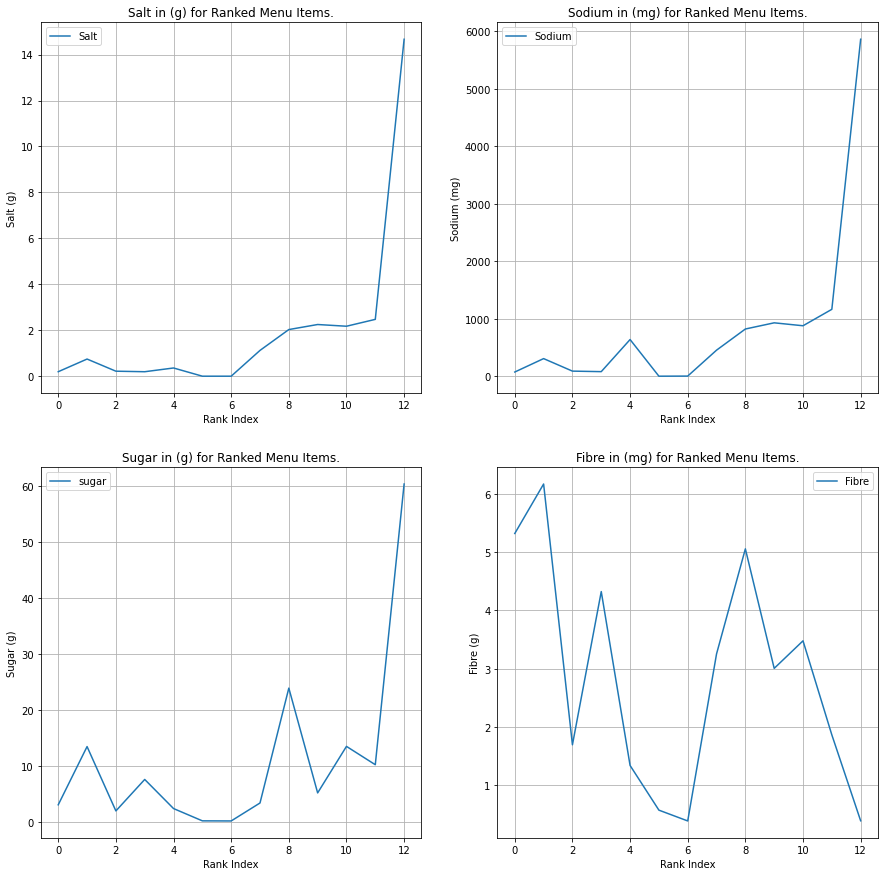

In [10]:
#Generate plots per nutrient
generate_plots(df_main, 'Salt', 'Sodium', 'Fibre', 'Sugar')

* Correlation Heat Map: Visualisation of the correlation of different nutrients with the target variable which is the eat-well score.

* Blue pixels indicate a negative correlation between the 2 parameters on x and y axis, grey pixels show that the 2 matched parameters are not correlated and orange/red pixels indicate a positive correlation. 

* On the first column of the heat map from the left, we see that Sodium, Salt and Sugar have the strongest negative correlation with Eat-Well score, while Omega 3, Omega 6 and Fibre indicate a positive correlation. Saturate, Trans Fat and Fat indicate a non-correlation to Eat-Well score. However this is not an accurate case, as we know that Fat and Trans Fat for instance affect negatively Eat-Well score. This is the case where lack of data (recipes) may lead to weak judgements.

We will expand current nutrient annotations to include a larger amount of recipes, which will be scored by eat-well algorithm and provide a complete picture of the trade-offs between different nutrient properties and their contribution to the meals's final score.

In [21]:
for col in list(df_main.columns)[1:]:
    df_main[col] = pd.to_numeric(df_main[col], downcast="float")

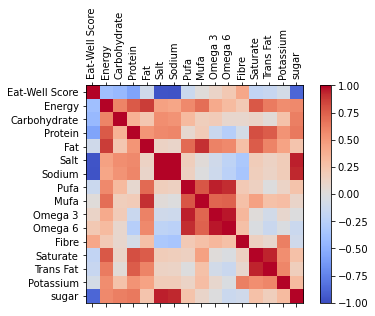

In [12]:
#Generate a Heat Map to examine correlation amongst different nutrients and the target variable, score.
#df_main = df_main.drop(["category", "menu_type"], axis=1)
corr = df_main.corr()
from matplotlib.pyplot import figure

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_main.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_main.columns)
ax.set_yticklabels(df_main.columns)

plt.show()

# Eat-Well sorted menu-items and their ingredients

In [13]:
#Eat-Well Re-ranked menu items 
df = pd.DataFrame([allergens_free_menu_items, total_nutrition_values[0], scores]).T
df.columns = ["Menu-Items", "Ingredients", "Eat-Well Score"]

df = df.sort_values(by ='Eat-Well Score', ascending=False).reset_index()
pd.set_option('max_colwidth', 400)
df = df.set_index("Menu-Items")
df = df.drop(["index"], axis=1)
df

,Ingredients,Eat-Well Score
Menu-Items,,
Roasted Fingerling Potatoes with Fresh Herbs and Garlic,"[ garlic clove, rosemary, fingerling potato, extra virgin olive oil, thyme, sage, salt]",0.984351
Tequila Laced Gazpacho Cocktails with Grilled Shrimp,"[ oil, garlic clove, cucumber, extra virgin olive oil, fennel bulb, tequila, italian parsley, zatar, tomato juice, sherry vinegar, salt, red onion, tomato]",0.973406
Curried Rice With Smoked Trout,"[ plum tomato, onion, curry powder, extra virgin olive oil, lemon, egg, basmati rice, salt, cilantro]",0.892964
Grilled Steak Fries with Citrus-Thyme Aioli,"[ garlic clove, russet potato, thyme leaves, mayonnaise, orange zest, lemon zest, canola oil, honey, salt]",0.844178
Grilled Fish Tacos with Vera Cruz Salsa,"[ plum tomato, jalapeno, ancho chile powder, dried mexican oregano, napa, red wine vinegar, barely chopped fresh cilantro, olive oil, caper, halibut, canola oil, cilantro, salsa, salt, red onion, manzanilla olives]",0.795521
Roasted Beet and Lentil Dip,"[ can organic low, garlic clove, walnut, extra virgin olive oil, thyme, red wine vinegar, salt]",0.793343
Spaghetti Aglio e Olio,"[ garlic clove, red pepper, extra virgin olive oil, parsley, salt]",0.754796
Salami Salad,"[ extra virgin olive oil, fennel bulb, grape tomato, salami, baby arugula, salt]",0.662269
Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise,"[ oil, onion, bread crumbs, bell pepper, yellow onion, ground chuck, mayonnaise, adobo seasoning, oaxaca cheese, chili, brown sugar, salt, sirloin, raw chorizo]",0.546354


## Eat-Well Ranking Evaluation

* To evaluate eat-well algorithm scoring of various menu items, we calculate Rank-Biased Overlap (RBO) between 2 lists of items - eat-well rankings for a given set of menu items and the respective rankings for the same set of menu items generated by specialised nutritionists.

* RBO compares two ranked lists, and returns a numeric value between zero and one to quantify their similarity. A RBO value of zero indicates the lists are completely different, and a RBO of one means completely identical.


In [14]:
ground_truth_ratings = {
    "breakfast_seafood": [],
    "breakfast_vegetarian": [],
    "breakfast_ovo_vegetarian": [],
    "breakfast_dairy_vegetarian": [],
    "breakfast_vegetarian_only": [],
    "breakfast_vegan": [],
    "breakfast_omnivorous_meat_dishes_only": [],
    "all_breakfast_dishes": [],
    "lunch_seafood": ["Grilled fish tacos with Vera Cruz Salsa", "Curried rice with smoked trout", "Tequila laced Gazpacho Cocktails with grilled shrimp"],
    "lunch_vegetarian": [],
    "lunch_ovo_vegetarian": ["Grilled steak fries with citrus-thyme aioli"],
    "lunch_dairy_vegetarian": [],
    "lunch_vegetarian_only": [],
    "lunch_vegan": ["Coconut-curry wheat berries and rice", "Roasted beet and lentil dip", "Roasted fingerling potatoes"],
    "lunch_omnivorous_meat_dishes_only": ["Greek Lamb meatball sliders with tzatziki", "Salami salad", "Adobo Buffalo wings"],
    "all_lunch_dishes": ["Grilled fish tacos with Vera Cruz salsa", "Curried rice with smoked trout", "Coconut-curry wheat berries and rice", "Greek lamb meatball sliders with tzatziki", "Tequila laced Gazpacho cocktails with grilled shrimp", "Roasted beet and lentil dip", "roasted fingerling potatoes", "grilled steak fries with citrus-thyme aioli", "salami salad", "adobo buffalo wings"],
    "dinner_seafood": ["Grilled fish tacos with Vera Cruz Salsa", "Curried rice with smoked trout", "Tequila laced Gazpacho Cocktails with grilled shrimp", "Fool-i-ya-basie Seafood stew"],
    "dinner_vegetarian": [],
    "dinner_ovo_vegetarian": ["Grilled steak fries with citrus-thyme aioli"],
    "dinner_dairy_vegetarian": [],
    "dinner_vegetarian_only": [],
    "dinner_vegan": ["Coconut-curry wheat berries and rice", "Spaghetti Aglio e Olio"],
    "dinner_omnivorous_meat_dishes_only": ["Thai lettuce wraps", "Fool-i-ya-basie Seafoodstew", "Greek Lamb meatball sliders with tzatziki", "Salami salad", "Latin burgers with caramelised onion and jalapeno relish and red pepper mayonnaise", "Adobo Buffalo wings"],
    "all_dinner_dishes": ["Grilled fish tacos with Vera cruz salsa", "thai lettuce wraps", "curried rice with smoked trout", "Fool-i-ya-basie seafood stew", "Tequila laced gazpacho cocktails with grilled shrimp", "Greek lamb meatball sliders with tzatziki", "coconut-curry wheat berries and rice", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "grilled steak fries with citrus-thyme aioli", "spaghetti aglio e olio", "adobo buffalo wings"]
    
}

In [15]:
eat_well_ratings = {
    "breakfast_seafood": ["Coconut-Curry Wheat Berries and Rice", "Cherry Shells"],
    "breakfast_vegetarian": ["Coconut-Curry Wheat Berries and Rice", "Cherry Shells"],
    "breakfast_ovo_vegetarian": [],
    "breakfast_dairy_vegetarian": [],
    "breakfast_vegetarian_only": [],
    "breakfast_vegan": ["Coconut-Curry Wheat Berries and Rice"],
    "breakfast_seafood_only": [],
    "breakfast_omnivorous_meat_dishes_only": [],
    "all_breakfast_dishes": ["Coconut-Curry Wheat Berries and Rice", "Cherry Shells"],
    "lunch_seafood": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Curried Rice With Smoked Trout", "Roasted Beet and Lentil Dip", "Coconut-Curry Wheat Berries and Rice", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Grilled Fish Tacos with Vera Cruz Salsa", "Spaghetti Aglio e Olio", "Grilled Steak Fries with Citrus-Thyme Aioli"],
    "lunch_vegetarian": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic"],
    "lunch_ovo_vegetarian": [],
    "lunch_dairy_vegetarian": [],
    "lunch_vegetarian_only": [],
    "lunch_vegan": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Coconut-Curry Wheat Berries and Rice", "Roasted Beet and Lentil Dip", "Spaghetti Aglio e Olio"],
    "lunch_seafood_only": ["Curried Rice With Smoked Trout", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Grilled Fish Tacos with Vera Cruz Salsa"],
    "lunch_omnivorous_meat_dishes_only": ["Salami Salad", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "Fool-i-ya-baise Seafood Stew", "Greek Lamb Meatball Sliders with Tzatziki", "Thai Lettuce Wraps", "Adobo Buffalo Wings"],
    "all_lunch_dishes": ["Curried Rice With Smoked Trout", "Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Roasted Beet and Lentil Dip", "Grilled Fish Tacos with Vera Cruz Salsa", "Coconut-Curry Wheat Berries and Rice", "Spaghetti Aglio e Olio", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Fool-i-ya-baise Seafood Stew", "Grilled Steak Fries with Citrus-Thyme Aioli", "Salami Salad", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "Thai Lettuce Wraps", "Greek Lamb Meatball Sliders with Tzatziki", "Adobo Buffalo Wings"],
    "dinner_seafood": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Curried Rice With Smoked Trout", "Roasted Beet and Lentil Dip", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Grilled Fish Tacos with Vera Cruz Salsa", "Spaghetti Aglio e Olio", "Grilled Steak Fries with Citrus-Thyme Aioli"],
    "dinner_vegetarian": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Roasted Beet and Lentil Dip", "Spaghetti Aglio e Olio", "Grilled Steak Fries with Citrus-Thyme Aioli"],
    "dinner_ovo_vegetarian": [],
    "dinner_dairy_vegetarian": [],
    "dinner_vegetarian_only": [],
    "dinner_vegan": ["Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Coconut-Curry Wheat Berries and Rice", "Roasted Beet and Lentil Dip", "Spaghetti Aglio e Olio"],
    "dinner_seafood_only": ["Curried Rice With Smoked Trout", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Grilled Fish Tacos with Vera Cruz Salsa"],
    "dinner_omnivorous_meat_dishes_only": ["Salami Salad", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "Fool-i-ya-baise Seafood Stew", "Greek Lamb Meatball Sliders with Tzatziki", "Thai Lettuce Wraps", "Adobo Buffalo Wings"],
    "all_dinner_dishes": ["Curried Rice With Smoked Trout", "Roasted Fingerling Potatoes with Fresh Herbs and Garlic", "Roasted Beet and Lentil Dip", "Grilled Fish Tacos with Vera Cruz Salsa", "Spaghetti Aglio e Olio", "Tequila Laced Gazpacho Cocktails with Grilled Shrimp", "Fool-i-ya-baise Seafood Stew", "Grilled Steak Fries with Citrus-Thyme Aioli", "Salami Salad", "Latin Burgers with Caramelized Onion and Jalapeno Relish and Red Pepper Mayonnaise", "Thai Lettuce Wraps", "Greek Lamb Meatball Sliders with Tzatziki", "Adobo Buffalo Wings"]
}

In [16]:
import math

def rbo(list1, list2, p=0.9):
   # tail recursive helper function
    def helper(ret, i, d):
        l1 = set(list1[:i]) if i < len(list1) else set(list1)
        l2 = set(list2[:i]) if i < len(list2) else set(list2)
        a_d = len(l1.intersection(l2))/i
        term = math.pow(p, i) * a_d
        if d == i:
            return ret + term
        return helper(ret + term, i + 1, d)
    k = max(len(list1), len(list2))
    x_k = len(set(list1).intersection(set(list2)))
    summation = helper(0, 1, k)
    return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

In [17]:
df = pd.DataFrame([ground_truth_ratings["all_lunch_dishes"], eat_well_ratings["all_lunch_dishes"]]).T
df.columns = ["Nutritionist Ranking", "Eat-Well Ranking"]
df

,Nutritionist Ranking,Eat-Well Ranking
0,Grilled fish tacos with Vera Cruz salsa,Curried Rice With Smoked Trout
1,Curried rice with smoked trout,Roasted Fingerling Potatoes with Fresh Herbs and Garlic
2,Coconut-curry wheat berries and rice,Roasted Beet and Lentil Dip
3,Greek lamb meatball sliders with tzatziki,Grilled Fish Tacos with Vera Cruz Salsa
4,Tequila laced Gazpacho cocktails with grilled shrimp,Coconut-Curry Wheat Berries and Rice
5,Roasted beet and lentil dip,Spaghetti Aglio e Olio
6,roasted fingerling potatoes,Tequila Laced Gazpacho Cocktails with Grilled Shrimp
7,grilled steak fries with citrus-thyme aioli,Fool-i-ya-baise Seafood Stew
8,salami salad,Grilled Steak Fries with Citrus-Thyme Aioli
9,adobo buffalo wings,Salami Salad


In [18]:
rbo_score = rbo([i.lower() for i in ground_truth_ratings["all_lunch_dishes"]], [i.lower() for i in eat_well_ratings["all_lunch_dishes"]])
print("RBO similarity between 2 menu-item rankings: \n\n", rbo_score)

RBO similarity between 2 menu-item rankings: 

 0.5321330615808252


In [19]:
from IPython.display import HTML
HTML('<iframe src=https://q4-food-images.s3.eu-west-1.amazonaws.com/SWOT_InnovateUK.pdf width=1400 height=650></iframe>')


/Users/kostaspsychogyio/opt/anaconda3/envs/orbit/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
